In [1]:
#Bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import glob

In [2]:
#Dados
os.chdir("C:/Users/User/Desktop/MarkV/")

In [3]:
dfs = []

for planilha in glob.glob("data/Predictions/*.csv"):
    df = pd.read_csv(planilha)
    dfs.append(df)

df_final = pd.concat(dfs, ignore_index=True)

# Verificar
print(f"Total de linhas combinadas: {df_final.shape[0]}")
print(df_final.head())

Total de linhas combinadas: 149
  Sample                              Node              XGB              RF
0   NF10  NODE_18_length_2064_cov_2.646200   Sedoreoviridae  Sedoreoviridae
1   NF10  NODE_54_length_1472_cov_2.822222     Astroviridae  Hepadnaviridae
2   NF10  NODE_224_length_960_cov_8.497589  Spinareoviridae  Sedoreoviridae
3   NF10  NODE_430_length_750_cov_5.506686   Sedoreoviridae  Sedoreoviridae
4   NF10  NODE_512_length_707_cov_1.630159   Sedoreoviridae   Matonaviridae


In [4]:
df_final['Sample_num'] = df_final['Sample'].str.extract(r'NF(\d+)').astype(int)
df_final = df_final.sort_values(by='Sample_num').drop(columns='Sample_num')

In [5]:
df_final.head()

,Sample,Node,XGB,RF
108,NF1,NODE_273_length_573_cov_0.887097,Sedoreoviridae,Sedoreoviridae
111,NF1,NODE_383_length_518_cov_1.498866,Sedoreoviridae,Anelloviridae
110,NF1,NODE_342_length_534_cov_7033.369803,Sedoreoviridae,Anelloviridae
109,NF1,NODE_286_length_569_cov_1.247967,Anelloviridae,Anelloviridae
107,NF1,NODE_260_length_581_cov_13221.982143,Sedoreoviridae,Anelloviridae


C:\Users\User\AppData\Local\Temp\ipykernel_12412\2690776202.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
C:\Users\User\AppData\Local\Temp\ipykernel_12412\2690776202.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


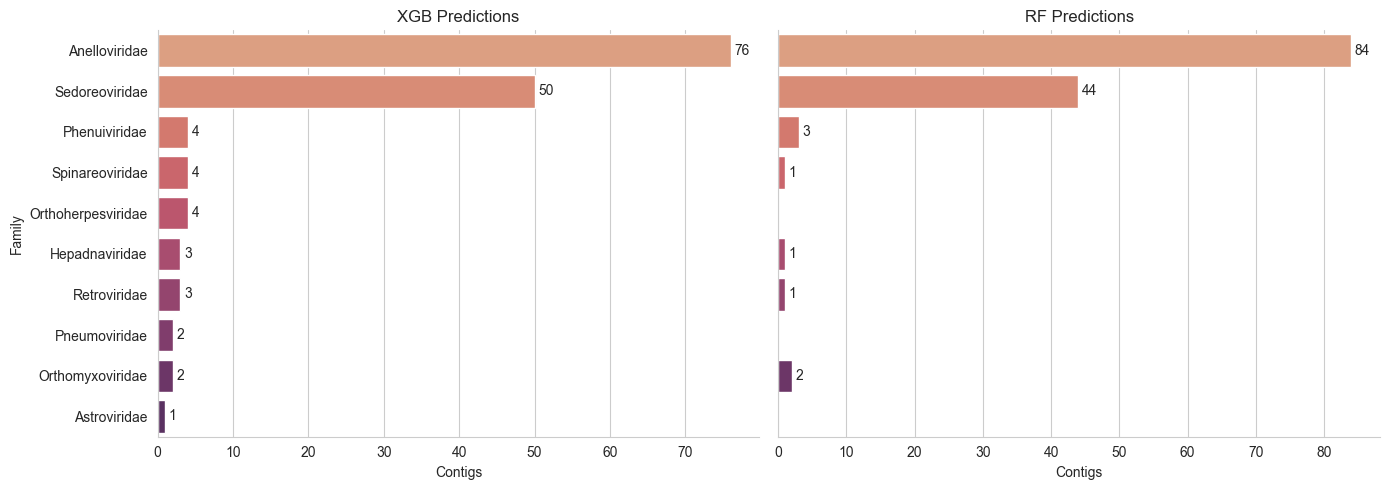

In [6]:
# Plotar o gráfico
sns.set_style("whitegrid")

# Ordem baseada no XGB
order_families = df_final['XGB'].value_counts().index

fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
palette = sns.color_palette("flare", n_colors=len(order_families))

# XGB
sns.countplot(
    data=df_final,
    y='XGB',
    order=order_families,
    palette=palette,
    ax=axs[0]
)
axs[0].set_title("XGB Predictions")
axs[0].set_ylabel("Family")
axs[0].set_xlabel("Contigs")
for p in axs[0].patches:
    axs[0].annotate(
        int(p.get_width()),
        (p.get_width() + 0.5, p.get_y() + p.get_height() / 2),
        va='center'
    )

# RF com a mesma ordem de famílias
sns.countplot(
    data=df_final,
    y='RF',
    order=order_families,
    palette=palette,
    ax=axs[1]
)
axs[1].set_title("RF Predictions")
axs[1].set_xlabel("Contigs")
for p in axs[1].patches:
    axs[1].annotate(
        int(p.get_width()),
        (p.get_width() + 0.5, p.get_y() + p.get_height() / 2),
        va='center'
    )

sns.despine()
plt.tight_layout()
plt.show()

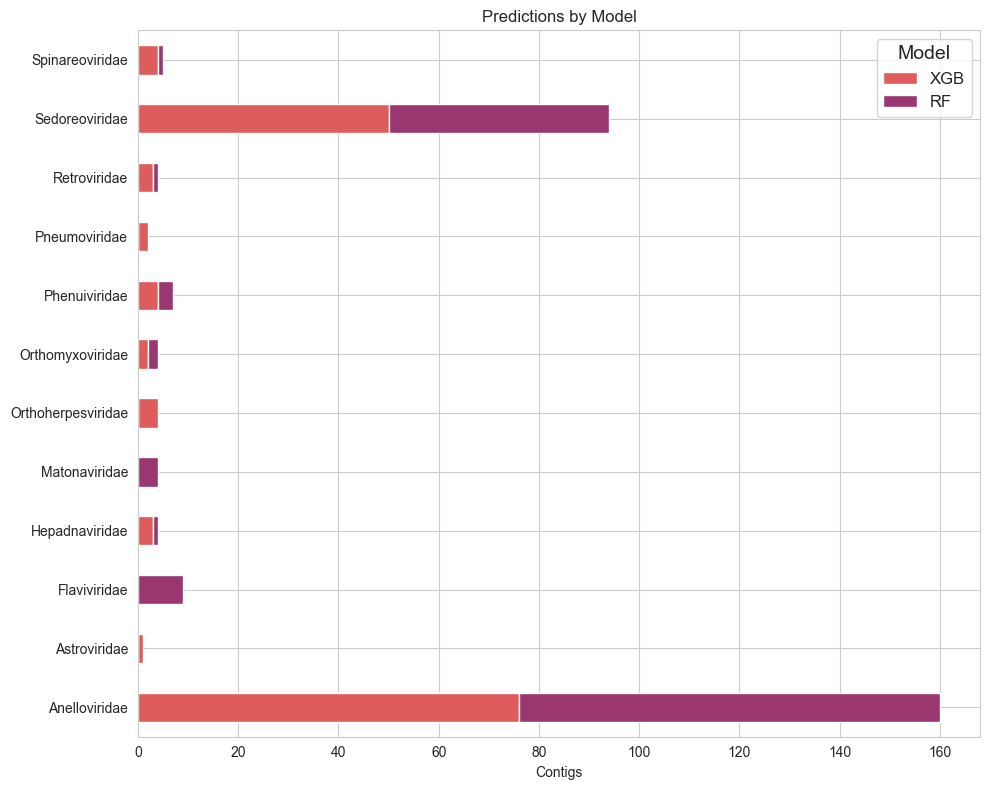

In [11]:
sns.set_style("whitegrid")

# Contagem por modelo
xgb_counts = df_final['XGB'].value_counts().rename("XGB")
rf_counts = df_final['RF'].value_counts().rename("RF")

all_families = sorted(set(xgb_counts.index) | set(rf_counts.index))
df_counts = pd.DataFrame(index=all_families)
df_counts['XGB'] = xgb_counts
df_counts['RF'] = rf_counts
df_counts = df_counts.fillna(0)

# Plot
df_counts.plot(
    kind='barh',
    stacked=True,
    figsize=(10, 8),
    color=sns.color_palette("flare", 2)
)

plt.xlabel("Contigs")
plt.ylabel("")
plt.title("Predictions by Model")
plt.legend(title="Model", fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()

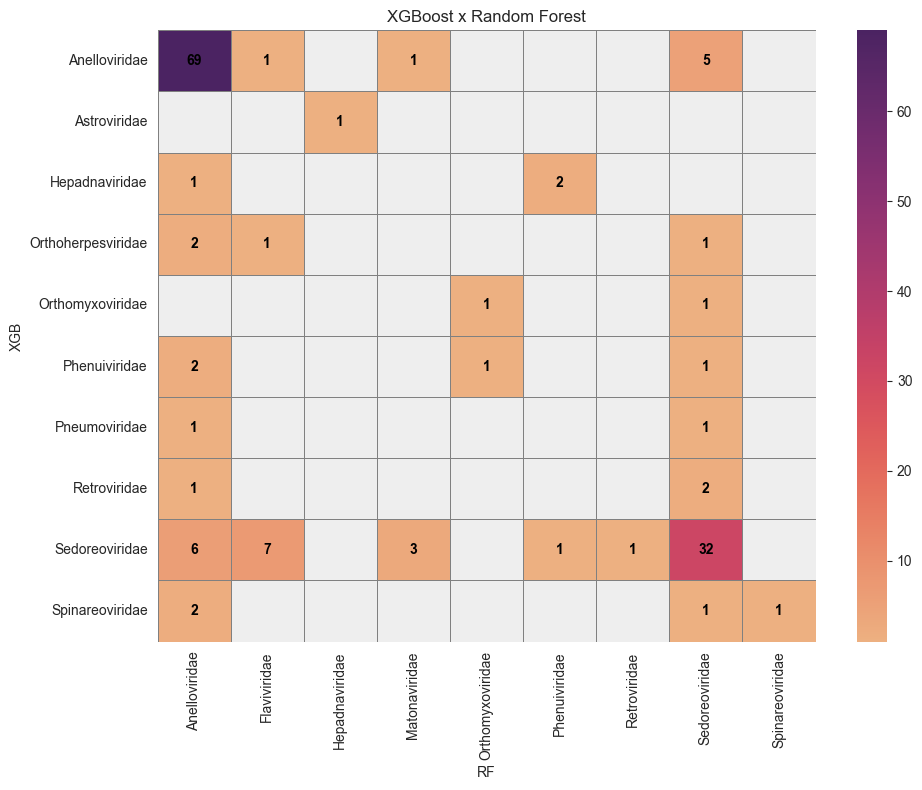

In [12]:
concord = pd.crosstab(df_final['XGB'], df_final['RF'])


# Criar uma máscara para os zeros
mask_zeros = concord == 0

# Criar a figura
plt.figure(figsize=(10, 8))

# Primeiro: plotar os zeros em cinza claro
sns.heatmap(
    concord,
    mask=~mask_zeros,          # só deixa visíveis os zeros
    cmap=sns.color_palette(["#eeeeee"], as_cmap=True),  # cinza claro
    annot=False,
    cbar=False
)

# Depois: plotar os valores >0 usando a paleta 'flare'
sns.heatmap(
    concord,
    mask=mask_zeros,           # esconde os zeros
    cmap="flare",
    annot=True,
    fmt='d',
    cbar=True,
    linewidths=0.5,
    linecolor='gray',
    annot_kws={"color": "black", "weight": "bold"}  # números bem visíveis
)

plt.title("XGBoost x Random Forest")
plt.ylabel("XGB")
plt.xlabel("RF")
plt.tight_layout()
plt.show()

In [13]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(df_final['RF'], df_final['XGB'])

0.4956956809653448

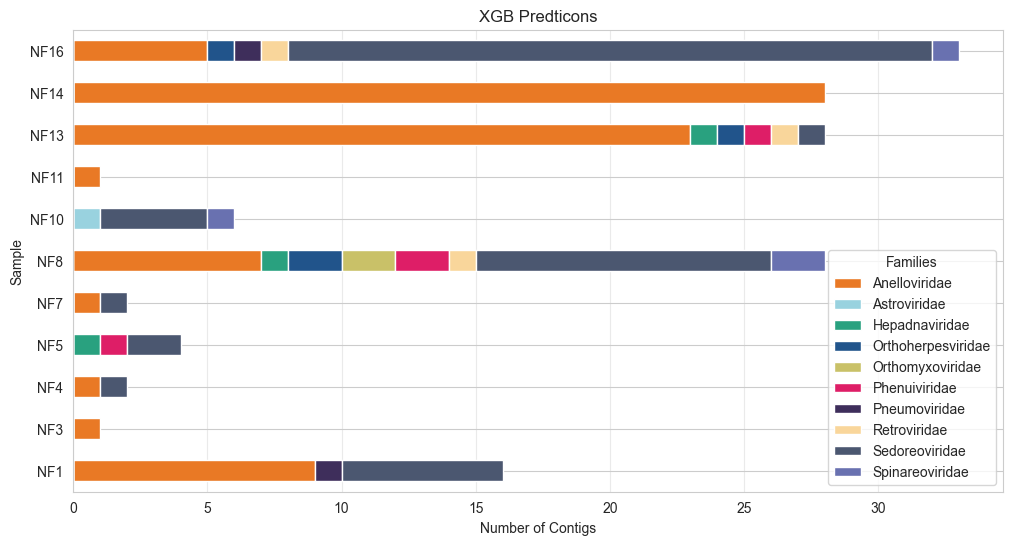

In [14]:
df_xgb = df_final.groupby(['Sample', 'XGB']).size().reset_index(name='Count')
#df_rf = df_final.groupby(['Sample', 'RF']).size().reset_index(name='Count')

# ordenação
df_xgb['Sample_num'] = df_xgb['Sample'].str.extract(r'NF(\d+)').astype(int)

# Ordenar antes de pivotar
df_xgb = df_xgb.sort_values('Sample_num')

# Remover a coluna auxiliar depois
df_xgb = df_xgb.drop(columns='Sample_num')

# Agora faz o pivot e o gráfico
xgb_pivot = df_xgb.pivot(index='Sample', columns='XGB', values='Count').fillna(0)

# Reordenar o índice do pivot conforme a ordem numérica
xgb_pivot = xgb_pivot.loc[sorted(xgb_pivot.index, key=lambda x: int(x.replace('NF', '')))]


colors = ['#E97925', '#99D2DF', '#29A17F', '#21548B', '#C9C168', '#DE1E67', "#3E2E5B", "#F9D69B", "#4B5770", "#6971B0"]

# Gráfico empilhado para XGB
#xgb_pivot = df_xgb.pivot(index='Sample', columns='XGB', values='Count').fillna(0)
xgb_pivot.plot(kind='barh', stacked=True, figsize=(12, 6), color = colors)
plt.title('XGB Predticons')
plt.xlabel('Number of Contigs')
plt.grid(alpha = 0.4, axis = "x")
plt.legend(title = "Families", loc = "best")
plt.show()

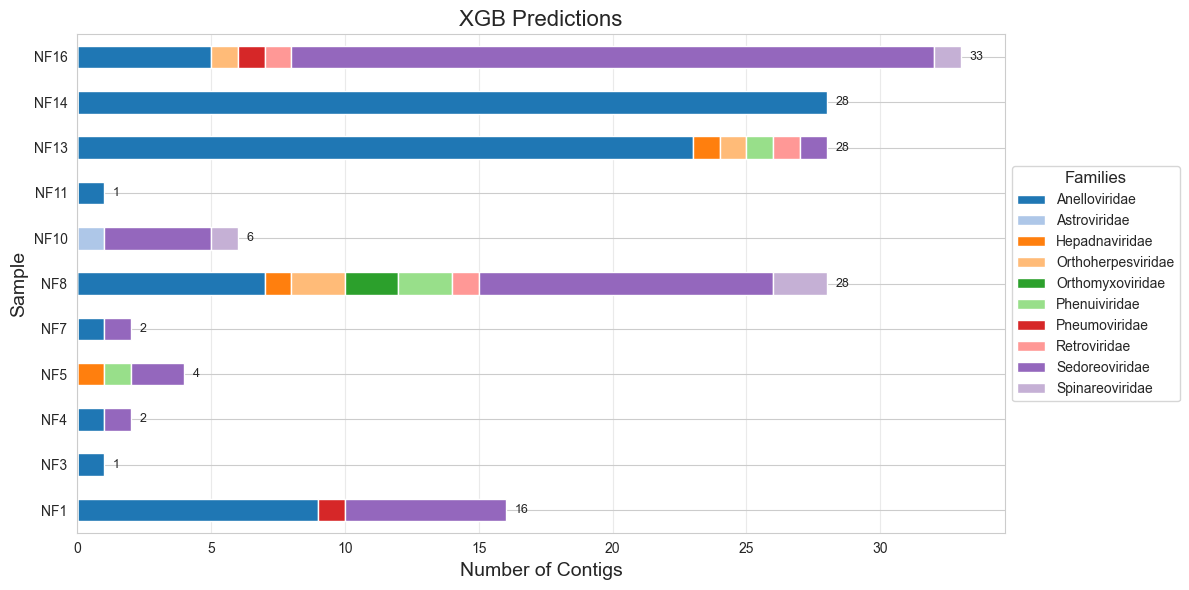

In [15]:
palette = sns.color_palette("tab20", n_colors=len(xgb_pivot.columns))

# Plot
ax = xgb_pivot.plot(
    kind='barh',
    stacked=True,
    figsize=(12, 6),
    color=palette
)

# Título e eixos
plt.title('XGB Predictions', fontsize=16)
plt.xlabel('Number of Contigs', fontsize=14)
plt.ylabel('Sample', fontsize=14)
plt.grid(alpha=0.4, axis="x")

# Ajustar legenda
plt.legend(
    title="Families",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=10,
    title_fontsize=12
)

# Anotar valores no final da barra
for i, total in enumerate(xgb_pivot.sum(axis=1)):
    ax.text(total + max(xgb_pivot.sum(axis=1)) * 0.01, i, str(int(total)),
            va='center', fontsize=9)

plt.tight_layout()
plt.savefig("XGB_Predito.svg", dpi = 300, format = "svg")
plt.show()


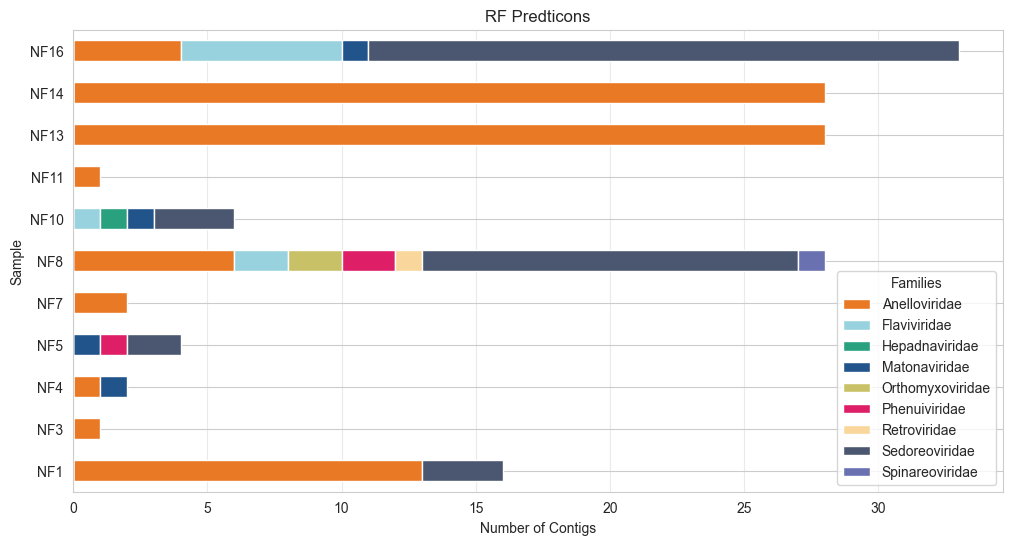

In [16]:
df_rf = df_final.groupby(['Sample', 'RF']).size().reset_index(name='Count')

# ordenação
df_rf['Sample_num'] = df_rf['Sample'].str.extract(r'NF(\d+)').astype(int)

# Ordenar antes de pivotar
df_rf = df_rf.sort_values('Sample_num')

# Remover a coluna auxiliar depois
df_rf = df_rf.drop(columns='Sample_num')

# Agora faz o pivot e o gráfico
rf_pivot = df_rf.pivot(index='Sample', columns='RF', values='Count').fillna(0)

# Reordenar o índice do pivot conforme a ordem numérica
rf_pivot = rf_pivot.loc[sorted(rf_pivot.index, key=lambda x: int(x.replace('NF', '')))]


colors = ['#E97925', '#99D2DF', '#29A17F', '#21548B', '#C9C168', '#DE1E67', "#F9D69B", "#4B5770", "#6971B0"]

rf_pivot.plot(kind='barh', stacked=True, figsize=(12, 6), color = colors)
plt.title('RF Predticons')
plt.xlabel('Number of Contigs')
plt.grid(alpha = 0.4, axis = "x")
plt.legend(title = "Families", loc = "best")
plt.show()

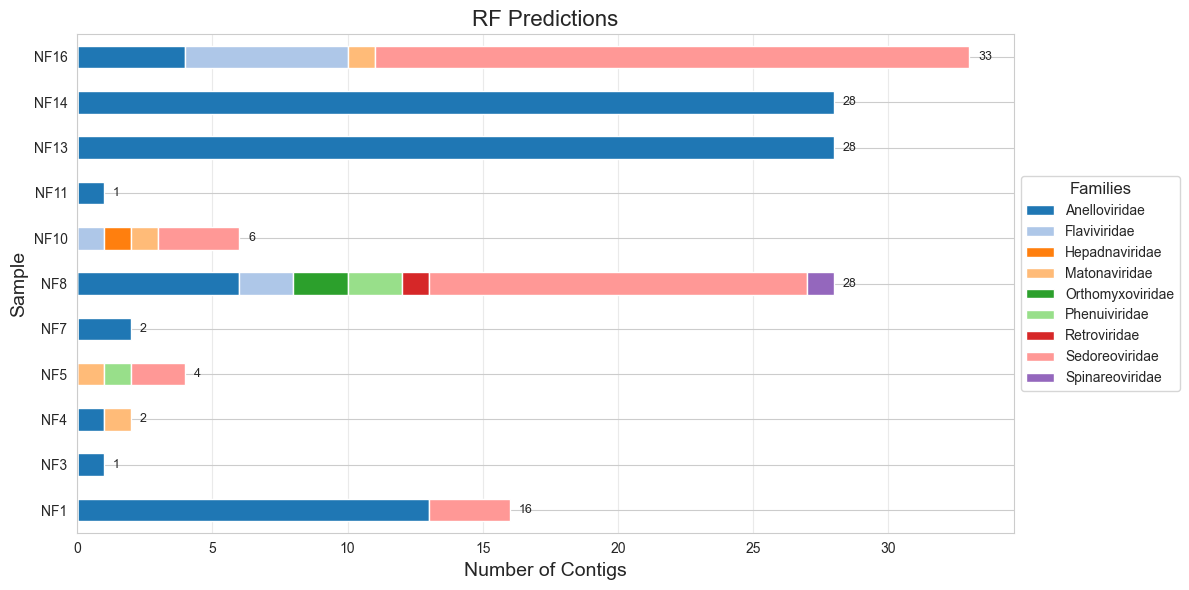

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Paleta personalizada (pode mudar se quiser manter consistência)
palette = sns.color_palette("tab20", n_colors=len(xgb_pivot.columns))

# Plot
ax = rf_pivot.plot(
    kind='barh',
    stacked=True,
    figsize=(12, 6),
    color=palette
)

# Título e eixos
plt.title('RF Predictions', fontsize=16)
plt.xlabel('Number of Contigs', fontsize=14)
plt.ylabel('Sample', fontsize=14)
plt.grid(alpha=0.4, axis="x")

# Ajustar legenda
plt.legend(
    title="Families",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=10,
    title_fontsize=12
)

# Anotar valores no final da barra
for i, total in enumerate(xgb_pivot.sum(axis=1)):
    ax.text(total + max(xgb_pivot.sum(axis=1)) * 0.01, i, str(int(total)),
            va='center', fontsize=9)

plt.tight_layout()
plt.savefig("RF_Predito.svg", dpi = 300, format = "svg")
plt.show()


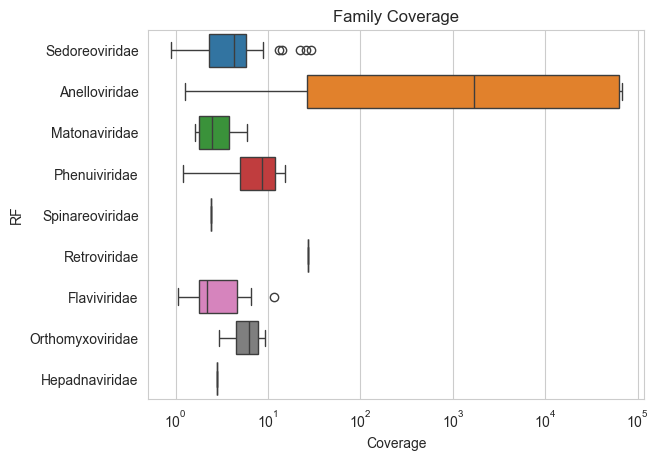

In [18]:
df_final['cov'] = df_final['Node'].str.extract(r'cov_([\d\.]+)').astype(float)


sns.boxplot(data=df_final, x='cov', y='RF', hue = "RF")
plt.xscale('log')
plt.title('Family Coverage')
plt.xlabel('Coverage')
plt.show()

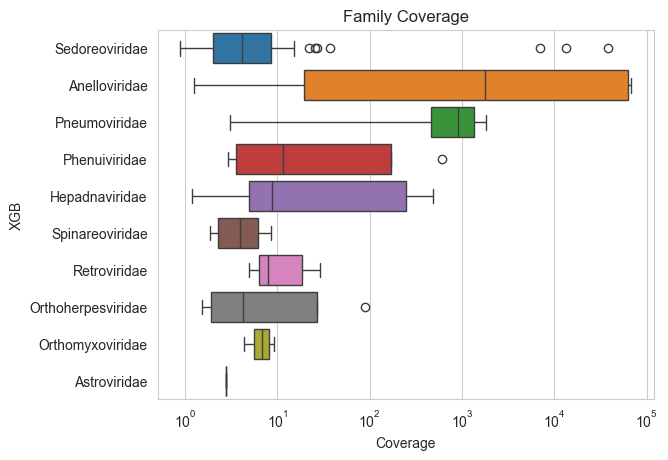

In [19]:
df_final['cov'] = df_final['Node'].str.extract(r'cov_([\d\.]+)').astype(float)


sns.boxplot(data=df_final, x='cov', y='XGB', hue = "XGB")
plt.xscale('log')
plt.title('Family Coverage')
plt.xlabel('Coverage')
plt.show()

In [20]:
df_final[df_final["RF"] == "Matonaviridae"]

,Sample,Node,XGB,RF,cov
114,NF4,NODE_177_length_594_cov_5.847195,Sedoreoviridae,Matonaviridae,5.847195
116,NF5,NODE_77_length_763_cov_1.848397,Sedoreoviridae,Matonaviridae,1.848397
4,NF10,NODE_512_length_707_cov_1.630159,Sedoreoviridae,Matonaviridae,1.630159
83,NF16,NODE_736_length_904_cov_3.038694,Anelloviridae,Matonaviridae,3.038694


In [21]:
xgb_pivot

XGB,Anelloviridae,Astroviridae,Hepadnaviridae,Orthoherpesviridae,Orthomyxoviridae,Phenuiviridae,Pneumoviridae,Retroviridae,Sedoreoviridae,Spinareoviridae
Sample,,,,,,,,,,
NF1,9.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6.0,0.0
NF3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NF4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
NF5,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0
NF7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
NF8,7.0,0.0,1.0,2.0,2.0,2.0,0.0,1.0,11.0,2.0
NF10,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0
NF11,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NF13,23.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0


In [41]:
df_final[df_final["Sample"] == "NF1"]

,Sample,Node,XGB,RF,cov
108,NF1,NODE_273_length_573_cov_0.887097,Sedoreoviridae,Sedoreoviridae,0.887097
111,NF1,NODE_383_length_518_cov_1.498866,Sedoreoviridae,Anelloviridae,1.498866
110,NF1,NODE_342_length_534_cov_7033.369803,Sedoreoviridae,Anelloviridae,7033.369803
109,NF1,NODE_286_length_569_cov_1.247967,Anelloviridae,Anelloviridae,1.247967
107,NF1,NODE_260_length_581_cov_13221.982143,Sedoreoviridae,Anelloviridae,13221.982143
106,NF1,NODE_245_length_589_cov_1818.878906,Pneumoviridae,Anelloviridae,1818.878906
105,NF1,NODE_198_length_636_cov_1279.177102,Anelloviridae,Anelloviridae,1279.177102
104,NF1,NODE_86_length_785_cov_1552.711864,Anelloviridae,Anelloviridae,1552.711864
96,NF1,NODE_2_length_2432_cov_37659.103185,Sedoreoviridae,Anelloviridae,37659.103185
102,NF1,NODE_54_length_951_cov_44333.623570,Anelloviridae,Anelloviridae,44333.623570


In [23]:
NF1 = pd.read_csv("results/NF13_DarkMatter.csv")
#NF1.head()

In [80]:
linha = NF1[NF1['Node'] == "NODE_985_length_769_cov_19"]

# Selecionar apenas as colunas com valor > 1 (ignorando colunas não numéricas se necessário)
colunas_maior_que_1 = linha.select_dtypes(include='number').loc[:, (linha.select_dtypes(include='number') > 1).any()]

print(colunas_maior_que_1.columns.tolist())

[]


In [25]:
dfs = []

for planilha in glob.glob("data/Probs/*RF_probabilities.csv"):
    df = pd.read_csv(planilha)
    dfs.append(df)

df_probs = pd.concat(dfs, ignore_index=True)

print(df_probs.head())

   Adenoviridae  Anelloviridae  Arenaviridae  Astroviridae  Bornaviridae  \
0          0.00           0.06          0.00          0.02          0.00   
1          0.02           0.05          0.03          0.01          0.01   
2          0.00           0.04          0.00          0.02          0.00   
3          0.02           0.05          0.00          0.01          0.00   
4          0.00           0.08          0.00          0.01          0.01   

   Caliciviridae  Circoviridae  Coronaviridae  Filoviridae  Flaviviridae  ...  \
0           0.00          0.05           0.01          0.0          0.09  ...   
1           0.00          0.03           0.00          0.0          0.03  ...   
2           0.01          0.05           0.00          0.0          0.11  ...   
3           0.01          0.06           0.00          0.0          0.11  ...   
4           0.02          0.00           0.00          0.0          0.10  ...   

   Pneumoviridae  Polyomaviridae  Poxviridae  Redondovir

In [26]:
cols_to_exclude = ["Sample", "Node"]

df_probs.rename(
    columns={col: f"RF_{col}" for col in df_probs.columns if col not in cols_to_exclude},
    inplace=True
)

In [27]:
df_tudo = pd.merge(df_final, df_probs, how = "left", on = "Node")

In [28]:
df_tudo

,Sample,Node,XGB,RF,cov,RF_Adenoviridae,RF_Anelloviridae,RF_Arenaviridae,RF_Astroviridae,RF_Bornaviridae,...,RF_Picornaviridae,RF_Pneumoviridae,RF_Polyomaviridae,RF_Poxviridae,RF_Redondoviridae,RF_Retroviridae,RF_Rhabdoviridae,RF_Sedoreoviridae,RF_Spinareoviridae,RF_Togaviridae
0,NF1,NODE_273_length_573_cov_0.887097,Sedoreoviridae,Sedoreoviridae,0.887097,0.00,0.05,0.00,0.02,0.00,...,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.28,0.09,0.0
1,NF1,NODE_383_length_518_cov_1.498866,Sedoreoviridae,Anelloviridae,1.498866,0.01,0.09,0.02,0.00,0.00,...,0.04,0.00,0.00,0.00,0.01,0.01,0.00,0.08,0.08,0.0
2,NF1,NODE_342_length_534_cov_7033.369803,Sedoreoviridae,Anelloviridae,7033.369803,0.00,0.40,0.03,0.00,0.00,...,0.01,0.00,0.00,0.00,0.00,0.01,0.01,0.03,0.04,0.0
3,NF1,NODE_286_length_569_cov_1.247967,Anelloviridae,Anelloviridae,1.247967,0.01,0.20,0.01,0.02,0.02,...,0.01,0.00,0.02,0.01,0.00,0.09,0.01,0.04,0.00,0.0
4,NF1,NODE_260_length_581_cov_13221.982143,Sedoreoviridae,Anelloviridae,13221.982143,0.00,0.17,0.03,0.02,0.01,...,0.05,0.01,0.06,0.00,0.03,0.03,0.01,0.11,0.01,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,NF16,NODE_450_length_1118_cov_1.864553,Sedoreoviridae,Flaviviridae,1.864553,0.02,0.11,0.00,0.00,0.00,...,0.00,0.01,0.00,0.00,0.00,0.02,0.00,0.15,0.04,0.0
145,NF16,NODE_448_length_1127_cov_13.189524,Sedoreoviridae,Sedoreoviridae,13.189524,0.00,0.12,0.01,0.01,0.00,...,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.17,0.10,0.0
146,NF16,NODE_365_length_1244_cov_4.565553,Sedoreoviridae,Flaviviridae,4.565553,0.01,0.08,0.00,0.00,0.01,...,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.14,0.03,0.0
147,NF16,NODE_1137_length_718_cov_2.051482,Sedoreoviridae,Sedoreoviridae,2.051482,0.01,0.04,0.01,0.12,0.00,...,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.20,0.02,0.0


In [29]:
dfs = []

for planilha in glob.glob("data/Probs/*XGB_probabilities.csv"):
    df = pd.read_csv(planilha)
    dfs.append(df)

df_probs_XGB = pd.concat(dfs, ignore_index=True)

print(df_probs_XGB.head())

   Adenoviridae  Anelloviridae  Arenaviridae  Astroviridae  Bornaviridae  \
0      0.007592       0.013945      0.006901      0.015867      0.006640   
1      0.015608       0.025846      0.017821      0.141520      0.015660   
2      0.009609       0.022770      0.011569      0.013086      0.012144   
3      0.002731       0.008406      0.002435      0.010549      0.003009   
4      0.001021       0.014435      0.001250      0.002133      0.000945   

   Caliciviridae  Circoviridae  Coronaviridae  Filoviridae  Flaviviridae  ...  \
0       0.007149      0.039900       0.006477     0.005395      0.009410  ...   
1       0.016861      0.022724       0.017528     0.012724      0.021107  ...   
2       0.010380      0.027182       0.009405     0.007834      0.016430  ...   
3       0.002572      0.004251       0.004931     0.001941      0.021126  ...   
4       0.000961      0.002064       0.000871     0.000725      0.001824  ...   

   Pneumoviridae  Polyomaviridae  Poxviridae  Redondovir

In [30]:
cols_to_exclude = ["Sample", "Node"]

df_probs_XGB.rename(
    columns={col: f"XGB_{col}" for col in df_probs_XGB.columns if col not in cols_to_exclude},
    inplace=True
)

In [31]:
df_todas_probs = pd.merge(df_tudo, df_probs_XGB, how = "left", on = "Node")

In [32]:
df_todas_probs.to_csv("Probs.csv")

In [50]:
df_todas_probs.shape

(149, 73)

In [42]:
exemplo = df_todas_probs[df_todas_probs["Sample"] == "NF1"]

In [43]:
exemplo[["Sample","Node", "RF", "XGB", "RF_Anelloviridae", "XGB_Sedoreoviridae", "XGB_Anelloviridae"]]

,Sample,Node,RF,XGB,RF_Anelloviridae,XGB_Sedoreoviridae,XGB_Anelloviridae
0,NF1,NODE_273_length_573_cov_0.887097,Sedoreoviridae,Sedoreoviridae,0.05,0.956085,0.007976
1,NF1,NODE_383_length_518_cov_1.498866,Anelloviridae,Sedoreoviridae,0.09,0.361893,0.026442
2,NF1,NODE_342_length_534_cov_7033.369803,Anelloviridae,Sedoreoviridae,0.40,0.579240,0.080879
3,NF1,NODE_286_length_569_cov_1.247967,Anelloviridae,Anelloviridae,0.20,0.045269,0.310698
4,NF1,NODE_260_length_581_cov_13221.982143,Anelloviridae,Sedoreoviridae,0.17,0.886530,0.024394
5,NF1,NODE_245_length_589_cov_1818.878906,Anelloviridae,Pneumoviridae,0.16,0.035975,0.027912
6,NF1,NODE_198_length_636_cov_1279.177102,Anelloviridae,Anelloviridae,0.26,0.017605,0.432630
7,NF1,NODE_86_length_785_cov_1552.711864,Anelloviridae,Anelloviridae,0.56,0.000052,0.999293
8,NF1,NODE_2_length_2432_cov_37659.103185,Anelloviridae,Sedoreoviridae,0.77,0.370461,0.199839
9,NF1,NODE_54_length_951_cov_44333.623570,Anelloviridae,Anelloviridae,0.82,0.000058,0.999575


In [6]:
comp = df_todas_probs[(df_todas_probs["RF"] == "Anelloviridae") & (df_todas_probs["Sample"] == "NF16")]

NameError: name 'df_todas_probs' is not defined

In [76]:
comp[["Sample","Node", "RF", "XGB", "RF_Anelloviridae", "XGB_Sedoreoviridae", "XGB_Anelloviridae"]]

,Sample,Node,RF,XGB,RF_Anelloviridae,XGB_Sedoreoviridae,XGB_Anelloviridae
122,NF16,NODE_54_length_2708_cov_304.278601,Anelloviridae,Anelloviridae,0.52,0.004611,0.885247
123,NF16,NODE_35_length_3010_cov_2596.916127,Anelloviridae,Anelloviridae,0.93,0.000002,0.999902
130,NF16,NODE_2162_length_503_cov_2.053991,Anelloviridae,Orthoherpesviridae,0.14,0.081851,0.078361
135,NF16,NODE_1237_length_684_cov_5.481054,Anelloviridae,Spinareoviridae,0.14,0.078357,0.038188


In [60]:
comp[comp["RF_Anelloviridae"] > 0.25].count()

Sample                 1
Node                   1
XGB                    1
RF                     1
cov                    1
                      ..
XGB_Retroviridae       1
XGB_Rhabdoviridae      1
XGB_Sedoreoviridae     1
XGB_Spinareoviridae    1
XGB_Togaviridae        1
Length: 73, dtype: int64

In [51]:
72/149

0.48322147651006714